<a href="https://colab.research.google.com/github/uts-strykers/braintumourdetection/blob/STRYK-3-Data-Preparation/Assignment2_BrainTumourDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STRYKERS TEAM: Brain Tumour Detection
Members:
Sotero Jr, Leon, Norah

##1. Project Overview: Brain Tumour Detection
Objective: Briefly describe the problem you're trying to solve.
Data Source: Mention where the data comes from and its main features.
Expected Outcome: Define what success looks like for this project.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/braintumourdetection

/content/drive/MyDrive/braintumourdetection


In [3]:
!git status

Refresh index: 100% (7/7), done.
On branch STRYK-4-Data-Ingestion
Your branch is ahead of 'origin/STRYK-4-Data-Ingestion' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Assignment2_BrainTumourDetection.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	coco_eval.py
	coco_utils.py
	engine.py
	transforms.py
	utils.py

no changes added to commit (use "git add" and/or "git commit -a")


#2. Import Libraries
Import necessary Python libraries (e.g., NumPy, pandas, Matplotlib, scikit-learn).

In [27]:
import matplotlib as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

import torch

from torchvision.io import read_image
from torchvision import tv_tensors

from torchvision.utils import draw_bounding_boxes

from torchvision.transforms.v2 import functional as F

from torchvision.ops.boxes import box_area
from torchvision.ops.boxes import box_convert

from glob import glob
from pathlib import Path

from tqdm.auto import tqdm


In [10]:
# download pycocotools
!pip install git+https://github.com/alperiox/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/alperiox/cocoapi.git to /tmp/pip-req-build-uuiblsyt
  Running command git clone --filter=blob:none --quiet https://github.com/alperiox/cocoapi.git /tmp/pip-req-build-uuiblsyt
  Resolved https://github.com/alperiox/cocoapi.git to commit 571a98e1ec2f16e8cd526767fd84e2c136309226
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375687 sha256=5c85525e42d3063a3fa8d1e693f0cddc182afe6403ab575f668f4c217c950807
  Stored in directory: /tmp/pip-ephem-wheel-cache-rsa0w_6k/wheels/8e/fc/f3/24daf824c3929e0eace6e743b70e259b36547b802868a93f5e
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [13]:
# get the scripts for training and COCO-related utility functions

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

#3. Data Collection
Loading Data: Code to load your dataset from a file or web API.
Initial Data Exploration: Display the first few rows of the dataset, list the features and their types.

In [14]:
dataset_path = '/content/drive/MyDrive/Brain Tumor Detection'

In [15]:
os.listdir(dataset_path)

['README.txt',
 'data.yaml',
 'test',
 'train',
 'valid',
 'brain-tumor-detection-with-torchvision.ipynb']

In [16]:
os.listdir(os.path.join(dataset_path, "valid", "images"))[:5]

['volume_269_slice_81_jpg.rf.eef98004083394ac813dea1546fc0635.jpg',
 'volume_269_slice_82_jpg.rf.2d347a5ecfdaaade21960c27d2d73284.jpg',
 'volume_26_slice_37_jpg.rf.4bf4c0a80500a515768496e4626e65c8.jpg',
 'volume_26_slice_46_jpg.rf.5191e4171a9c3a4773d415d051c588d5.jpg',
 'volume_26_slice_47_jpg.rf.d4d0ab1e6dfdec1d805b3ae935de1ca8.jpg']

In [17]:
os.listdir(os.path.join(dataset_path, "valid", "labels"))[:5]

['volume_277_slice_105_jpg.rf.339254917a6acacc8cdb7308fa55c783.txt',
 'volume_277_slice_109_jpg.rf.3c974773167a6b736ac39c8013045506.txt',
 'volume_277_slice_49_jpg.rf.5d71a4d970218fae0449d388fcc52563.txt',
 'volume_277_slice_51_jpg.rf.92056c2c10bbe33058f2d2573b1390f8.txt',
 'volume_277_slice_68_jpg.rf.564682bc9b0edab5e50a711cc3b057bb.txt']

In [18]:
with open(os.path.join(dataset_path, 'data.yaml'), "r") as stream:
    data = yaml.safe_load(stream)

data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 3,
 'names': ['label0', 'label1', 'label2'],
 'roboflow': {'workspace': 'yousef-ghanem-jzj4y',
  'project': 'brain-tumor-detection-fpf1f',
  'version': 2,
  'license': 'Public Domain',
  'url': 'https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f/dataset/2'}}

In [19]:
!cat /content/drive/MyDrive/"Brain Tumor Detection"/valid/labels/volume_114_slice_79_jpg.rf.fe0c58a00e797af3cbf938f1002b7e2e.txt

0 0.3057553956834532 0.5265151515151515 0.30935251798561153 0.25
1 0.24820143884892087 0.553030303030303 0.2949640287769784 0.3484848484848485
2 0.3057553956834532 0.5303030303030303 0.35251798561151076 0.2727272727272727

#4. Exploratory Data Analysis (EDA)
Statistical Summary: Describe the data statistically.
Visualization: Use plots (histograms, box plots, scatter plots) to visualize data and relationships.

tensor([1, 2], dtype=torch.int32) tensor([[ 79.,  87., 122., 113.],
        [ 98.,  98., 102., 100.]])


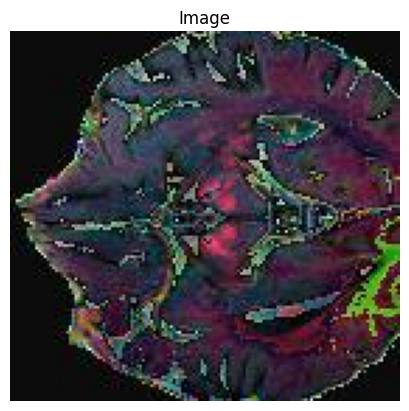

In [28]:
def plot_tensor(tensor: torch.Tensor, title: str="Image") -> None:
    plt.title(title)
    plt.axis("off")
    plt.imshow(tensor.permute(1,2,0).numpy())
    plt.show()

sample = read_image("/content/drive/MyDrive/Brain Tumor Detection/valid/images/volume_108_slice_59_jpg.rf.21ec09b0dc858d874774fb41faec4358.jpg")

with open("/content/drive/MyDrive/Brain Tumor Detection/valid/labels/volume_108_slice_59_jpg.rf.21ec09b0dc858d874774fb41faec4358.txt", "r") as f:
    labels = f.read()

labels = labels.split("\n")
labels = [label.split(" ") for label in labels]
h,w = F.get_size(sample)
label_indices = []
bboxes = []
for label in labels:
    l = int(label[0])
    cx, cy, bw, bh = list(map(float, label[1:]))
    # scale it given the image size
    bbox = [cx*w, cy*h, bw*w, bh*h]
    bbox = torch.Tensor(bbox)
    bbox = box_convert(bbox, in_fmt="cxcywh", out_fmt="xyxy")
    label_indices.append(l)
    bboxes.append(bbox)

labels = torch.tensor(label_indices).to(torch.int)
bboxes = torch.vstack(bboxes).to(torch.float)

print(labels, bboxes)

plot_tensor(sample)

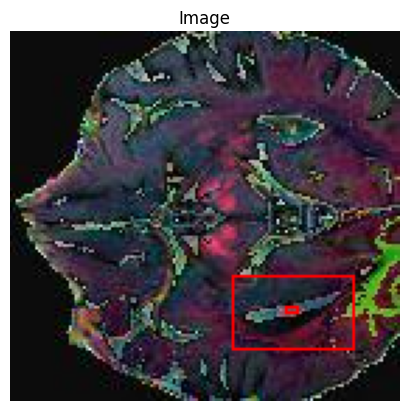

In [25]:
plot_tensor(draw_bounding_boxes(sample, bboxes, colors=[255,255]))

#5. Data Preprocessing
Cleaning: Handle missing values, remove duplicates, and deal with outliers.
Feature Engineering: Create new features from the existing data if necessary.
Feature Selection: Select relevant features for the model.
Data Transformation: Normalize or standardize data, encode categorical variables.

#6. Data Splitting
Split the data into training, validation, and test sets.


#7. Model Selection
Choose appropriate machine learning models for the problem.
Briefly describe each model's choice and its assumptions.


#8. Model Training
Training Models: Train models on the training dataset.
Hyperparameter Tuning: Use techniques like grid search or random search to find the best parameters.


#9. Model Testing

In [ ]:
# filter the predictions with the threshold of 0.4
pred_mask = (pred['scores'] >= .4).cpu()
# filter more by using non-maximum suppression with .6 as the threshold
nms_idx = nms(pred['boxes'], pred['scores'], .6).cpu()
nms_mask = torch.zeros_like(pred_mask)
nms_mask[nms_idx] = 1

mask = pred_mask * nms_mask # apply "AND" gate by multiplying the two

indices = torch.arange(0, mask.size(0), 1)[mask]

final_preds = {
    "boxes": pred['boxes'][indices, :],
    "labels": pred['labels'][indices],
    "scores": pred['scores'][indices]
}


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_labels = [f"label {label}: {score:.3f}" for label, score in zip(final_preds["labels"], final_preds["scores"])]
pred_boxes = final_preds["boxes"].long()
colors = ["white"]*len(pred_labels)

# resize the image and bounding boxes
pred_boxes = F.resize_bounding_boxes(pred_boxes, canvas_size=F.get_size(image), size=(132*5, 139*5))
image = F.resize(image, (132*5, 139*5), antialias=True)

print(image.shape, pred_boxes[1])

image_with_boxes = draw_bounding_boxes(image=image, boxes=pred_boxes[0], labels=pred_labels, colors=colors)

Image.fromarray(image_with_boxes.permute(1,2,0).numpy())

#9. Model Evaluation
Validation Performance: Evaluate model performance on the validation set using appropriate metrics (e.g., accuracy, F1 score, ROC AUC).
Cross-Validation: If necessary, perform cross-validation and discuss the results.


#10. Model Interpretation
Discuss model predictions and what they mean in the context of the problem.
Use interpretability tools or techniques if applicable (e.g., SHAP values).


#11. Model Deployment (Optional)
Discuss how the model could be deployed in a real-world application.
Mention any potential challenges and how they could be addressed.


#12. Conclusions
Summarize the key findings.
Discuss any limitations of the current approach and suggest improvements.


#13. References
Cite any references or resources used throughout the project.


#14. Appendix
Include any additional code or analysis that is supplementary to the main project.
This outline serves as a general guide for structuring your machine learning project in a Jupyter Notebook. Depending on the specifics of your project, some sections may need to be modified, expanded, or omitted.

In [34]:
!git status

On branch STRYK-3-Data-Preparation
Your branch is up to date with 'origin/STRYK-3-Data-Preparation'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	coco_eval.py
	coco_eval.py.1
	coco_utils.py
	coco_utils.py.1
	engine.py
	engine.py.1
	transforms.py
	transforms.py.1
	utils.py
	utils.py.1

nothing added to commit but untracked files present (use "git add" to track)


In [36]:
!git add Assignment2_BrainTumourDetection.ipynb

In [32]:
!git branch

* STRYK-3-Data-Preparation
  STRYK-4-Data-Ingestion
  main


In [21]:
!git config --global user.email "leonambrose.lusbo@student.uts.edu.au"
!git config --global user.name "Leon384"

In [37]:
!git commit -m "STRYK-3 Added Data Preparation"

On branch STRYK-3-Data-Preparation
Your branch is up to date with 'origin/STRYK-3-Data-Preparation'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	coco_eval.py
	coco_eval.py.1
	coco_utils.py
	coco_utils.py.1
	engine.py
	engine.py.1
	transforms.py
	transforms.py.1
	utils.py
	utils.py.1

nothing added to commit but untracked files present (use "git add" to track)


In [9]:
!ls /root/.ssh/id_rsa.pub

ls: cannot access '/root/.ssh/id_rsa.pub': No such file or directory


In [ ]:
!ssh -T git@github.com

Host key verification failed.


In [38]:
!git push -u origin STRYK-3-Data-Preparation

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
